In [5]:
import sys

sys.path.append("D:\code\pywfn")

from pywfn.data import sphGrid
from pywfn.base import Mol
from pywfn.reader import LogReader
from pywfn.atomprop import atomCharge

import matplotlib.pyplot as plt
import pyvista as pv
import numpy as np
import time
from sys import getsizeof

In [2]:
weight = sphGrid.gridData[:, -1]
coords = sphGrid.gridData[:, :3]
coords.setflags(write=False)

# path = "D:\BaiduSyncdisk\Articles\HFV\gfile\CH4.log"
path="D:\BaiduSyncdisk\gfile\elements\H2.out"
# path="D:\BaiduSyncdisk\gfile\C=C\CH2=CH2.out"
reader=LogReader(path)
mol = Mol(reader)
mol.bohr = True
atms = mol.obtAtms
shls = mol.obtShls
angs = mol.obtAngs
lmns = mol.basis.numAng(angs)

nmat = mol.CM.shape[0]
npos=len(weight)
nobt = len(mol.O_obts)
obts = mol.O_obts
nmat

4

## 定义函数

In [24]:
def get_wfn(i:int,pos:np.ndarray):
    """
    第i个基函数的波函数,pos为空间坐标
    """
    lmn = lmns[i]
    atm = atms[i]
    shl = shls[i]
    ang = sum(lmn)
    atmic = mol.atom(atm).atomic
    basis = mol.basis.get(atmic, shl, ang)
    exps = [b.exp for b in basis]
    coes = [b.coe for b in basis]
    pos_ = pos-mol.atom(atm).coord # 空间坐标-原子坐标=以原子为中心的空间坐标
    R2 = np.sum(pos_**2, axis=1)
    wfn = mol.gto.cgf(exps, coes, lmn, R2, pos_)  # 空间坐标-以原子为中心的坐标
    return wfn

def mol_den(pos):
    """计算分子的电子密度"""
    molDens=np.zeros(npos)
    for u in range(nmat):
        wfn_u=get_wfn(u,pos)
        for v in range(nmat):
            wfn_v=get_wfn(v,pos)
            molDens+=wfn_u*wfn_v*mol.PM[u,v]
    return molDens

def get_smi(u, v, pos):  # 重叠矩阵矩阵元
    wfn_u = get_wfn(u,pos)
    wfn_v = get_wfn(v,pos)
    smi = np.sum(wfn_u * wfn_v * weight)
    return smi

def get_pmi(u, v, pos):  # 势能矩阵矩阵元
    wfn_u = get_wfn(u,pos)
    wfn_v = get_wfn(v,pos)
    sr=np.zeros(npos)
    for atom in mol.atoms:
        r=np.linalg.norm(pos-atom.coord,axis=1)
        sr+=atom.atomic/r
    smi = np.sum(wfn_u * sr * wfn_v * weight)
    return smi

def get_jmi(u:int,v:int,pu:np.ndarray,pv:np.ndarray):
    ruv=np.linalg.norm(pu.reshape(1,-1)-pu.reshape(-1,1))
    wfn_u=get_wfn(u,pu)
    wfn_v=get_wfn(v,pu)
    mdens=mol_den(pv)
    print(ruv.shape)
    return np.sum(wfn_u*wfn_v*mdens/ruv)

In [36]:
pu=coords
duv=pu.reshape(-1,1,3)-pu.reshape(1,-1,3)
ruv=np.linalg.norm(duv,axis=2)

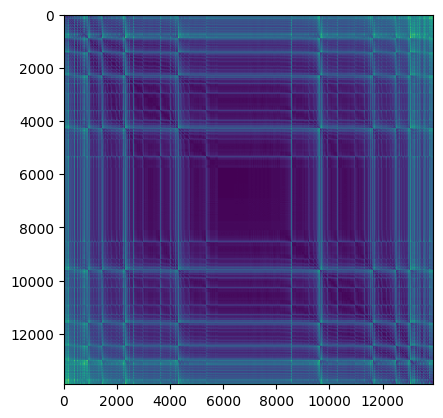

In [37]:
plt.imshow(ruv)

## 分子电子密度

In [78]:
# 全部展开求解
molDens=np.zeros(npos)
for o in obts:
    obtDens=np.zeros(npos) # 每个分子轨道的密度
    for u in range(nmat):
        pos=coords+mol.atom(atms[u]).coord # v和u应该使用相同的空间坐标啊
        # pos=coords
        wfn_u=get_wfn(u,pos)
        for v in range(nmat):
            wfn_v=get_wfn(v,pos)
            obtDens+=wfn_u*wfn_v*mol.CM[u,o]*mol.CM[v,o]*2
    print(np.sum(obtDens*weight))
    molDens+=obtDens
np.sum(molDens*weight)

1.9976272064864113
1.9991664395689233
2.0003402022224805
2.0003402022224805
2.00034020222248


9.997814252722776

In [84]:
# 直接使用密度矩阵计算分子电子密度，无法计算整个分子的波函数，因为对于不同原子，所采取的格点位置不同，虽然数量一致，但不能直接相加？
molDens=np.zeros(npos)
basDensl=[]
for u in range(nmat):
    pos=coords+mol.atom(atms[u]).coord # u处原子坐标
    basDens=np.zeros(npos)
    wfn_u=get_wfn(u,pos)
    for v in range(nmat):
        wfn_v=get_wfn(v,pos)
        basDens+=wfn_u*wfn_v*mol.PM[u,v]
    basDensl.append(np.sum(basDens*weight))
    molDens+=basDens
np.sum(molDens*weight)

9.997814252722776

In [86]:
# 每个原子的电子数量
for atom in mol.atoms:
    u,l=atom.obtBorder
    print(sum(basDensl[u:l]))

6.626755589818567
0.8427646657260525
0.8427646657260526
0.8427646657260525
0.8427646657260526


In [88]:
# 先计算出分子轨道波函数，然后求分子轨道密度
molDens=np.zeros(npos)
for o in obts:
    wfn=np.zeros(npos) # 分子轨道的波函数
    for u in range(nmat): # 每一个原子轨道
        pos=mol.atom(atms[u]).coord+coords # 每个原子的中心坐标都不一致
        wfn+=mol.CM[u,o]*get_wfn(u,coords) # 这里的坐标应该使用哪一个？，为什么使用pos不对？整个分子的电子密度，以分子为中心
    obtDens=wfn**2*weight*2
    molDens+=obtDens
    print(np.sum(obtDens))
print(np.sum(molDens))

1.9974183551720524
2.0020368730003684
2.00271389275077
2.00271389275077
2.00271389275077
10.00759690642473


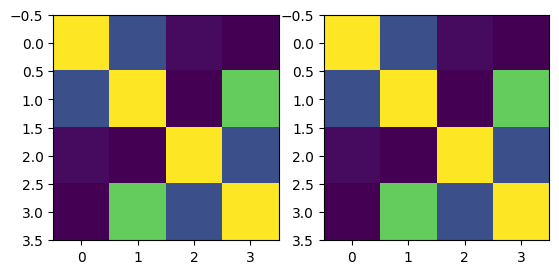

In [16]:
# 数值重叠积分与log重叠积分对比
fig,axs=plt.subplots(1,2)
SM=np.zeros(shape=(nmat,nmat))
for u in range(nmat):
    pu=mol.atom(atms[u]).coord
    for v in range(nmat):
        pv=mol.atom(atms[v]).coord
        pos=coords+(pu+pv)/2
        smi=get_smi(u,v,pos)
        SM[u,v]=smi
axs[0].imshow(SM) # 数值方法算出的重叠积分
axs[1].imshow(mol.SM) # log文件中读出的重叠积分
plt.show()

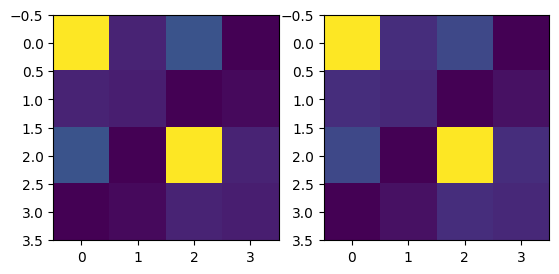

In [20]:
# 
mPE=reader.read_Mat('potential')
fig,axs=plt.subplots(1,2)
cPE=np.zeros(shape=(nmat,nmat))
for u in range(nmat):
    pu=mol.atom(atms[u]).coord
    for v in range(nmat):
        pv=mol.atom(atms[v]).coord
        pos=coords+(pu+pv)/2
        pmi=get_pmi(u,v,pos)
        cPE[u,v]=pmi
axs[0].imshow(cPE) # 数值方法算出的重叠积分
axs[1].imshow(mPE) # log文件中读出的重叠积分
plt.show()